In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from scipy.io import loadmat
from sklearn.model_selection import StratifiedKFold
from keras import layers

In [2]:
dataTT = loadmat(f"Data04-08_TT_UltVag_Cut.mat")

dataVG = loadmat(f"Data04-08_TF_UltVag_Cut.mat")

In [3]:
dataBaseline = dataTT['Baseline']
dataCincoP = dataTT['CincoP']
dataDez = dataTT['DezP']
dataVinte = dataTT['VinteP']

In [4]:
X_test = pd.DataFrame()

X_train = pd.DataFrame(dataBaseline)


dataCincoP_df = pd.DataFrame(dataCincoP)
X_test = pd.concat([X_test, dataCincoP_df], ignore_index=True)

dataDez_df = pd.DataFrame(dataDez)
X_test = pd.concat([X_test, dataDez_df], ignore_index=True)

dataVinte_df = pd.DataFrame(dataVinte)
X_test = pd.concat([X_test, dataVinte_df], ignore_index=True)

In [5]:
#O modelo tem que ser treinado apenas com os dados baseline? 
#Ver como monta o autoencoder
#Ver como representar a regressão a partir do encoder e pegar o MSE/MAE em relação ao dado analisado

In [6]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [7]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,5820,5821,5822,5823,5824,5825,5826,5827,5828,5829
0,0.332179,0.322156,0.312134,0.324365,0.337422,0.335790,0.325244,0.313052,0.296634,0.280217,...,-0.404234,-0.420915,-0.427830,-0.423002,-0.420707,-0.438448,-0.456189,-0.459560,-0.458648,-0.457411
1,0.386385,0.379305,0.364307,0.348443,0.340129,0.352088,0.364048,0.359345,0.345326,0.331428,...,-0.380740,-0.384124,-0.395138,-0.407912,-0.420737,-0.433787,-0.446837,-0.460072,-0.473456,-0.486840
2,0.196733,0.204847,0.193909,0.176075,0.176909,0.173954,0.161669,0.151720,0.143542,0.142185,...,-0.264166,-0.266663,-0.277983,-0.288434,-0.295890,-0.290828,-0.275072,-0.281777,-0.292735,-0.297212
3,0.321910,0.323861,0.331860,0.335426,0.324528,0.313631,0.304671,0.296135,0.295391,0.306014,...,-0.491216,-0.496316,-0.505899,-0.513626,-0.514413,-0.515201,-0.507789,-0.498291,-0.501124,-0.523807
4,0.303952,0.298020,0.303201,0.309421,0.319088,0.328755,0.308712,0.286715,0.285506,0.295734,...,-0.449191,-0.442378,-0.445943,-0.449280,-0.450386,-0.451493,-0.447657,-0.442582,-0.439880,-0.439493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.352563,0.350199,0.347836,0.350021,0.357670,0.365319,0.351699,0.335612,0.323804,0.320377,...,-0.414459,-0.426089,-0.437719,-0.436799,-0.430328,-0.428078,-0.452838,-0.477598,-0.503919,-0.531385
996,0.307783,0.309593,0.312903,0.312240,0.303620,0.295548,0.294303,0.293058,0.287178,0.280250,...,-0.349849,-0.343723,-0.358625,-0.385524,-0.400667,-0.396465,-0.392827,-0.393367,-0.393906,-0.397513
997,0.306879,0.304073,0.300413,0.295898,0.290179,0.287073,0.291591,0.295498,0.293633,0.291768,...,-0.321043,-0.316996,-0.310592,-0.310783,-0.315410,-0.326124,-0.344636,-0.359716,-0.365918,-0.371230
998,0.330445,0.337847,0.341394,0.339669,0.337945,0.340572,0.343458,0.344882,0.344627,0.344371,...,-0.524975,-0.524026,-0.529381,-0.534737,-0.534210,-0.530939,-0.528307,-0.528174,-0.528040,-0.546352


In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model
from scipy.optimize import minimize

# Função de custo para otimização
def cost_function(params, X_train):
    sparsity, rho, beta, epsilon, l1_lambda, weight_variance = params

    # Treinamento do modelo
    num_terms = X_train.columns.shape[0]
    input_layer = Input(shape=(num_terms,))
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu')(encoded)
    encoded_sparse = Dense(16, activation='relu', activity_regularizer=tf.keras.regularizers.l1(l1_lambda))(encoded)
    decoded = Dense(32, activation='relu')(encoded_sparse)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(num_terms, activation='sigmoid')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)

    activity_loss = beta * tf.keras.backend.sum(tf.keras.backend.square(rho - tf.keras.backend.mean(encoded_sparse, axis=0)))
    autoencoder.add_loss(activity_loss)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=epsilon)
    autoencoder.compile(optimizer=optimizer, loss='mse')
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=64, verbose=0)

    # Calcular a variância do loss
    losses = autoencoder.history.history["loss"]
    loss_variance = tf.math.reduce_variance(losses).numpy()

    # Ponderação entre a variância e o valor do loss
    weighted_loss = autoencoder.history.history["loss"][-1] + weight_variance * loss_variance

    return weighted_loss

# Seus dados de treinamento
# Substitua X_train pelos seus dados de treinamento

# Valores iniciais dos hiperparâmetros
initial_params = [0.1, 0.05, 3.0, 1e-5, 0.001, 0.1]

# Otimização dos hiperparâmetros
result = minimize(cost_function, initial_params, args=(X_train,), method='L-BFGS-B', bounds=[(0, 1), (0, 1), (0, None), (0, None), (0, None), (0, None)])

# Exibir os resultados otimizados
optimal_params = result.x
optimal_cost = result.fun

print("Hiperparâmetros otimizados:", optimal_params)
print("Custo otimizado:", optimal_cost)


KeyboardInterrupt: 

In [41]:
autoencoderEsparso(0.1, 0.05, 3.0, 1e-5, 0.001)

Epoch 1/50
16/16 [==============================] - 1s 19ms/step - loss: 5.3208
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 5.8848
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 6.3343
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 6.2351
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 6.3488
Epoch 6/50
16/16 [==============================] - 0s 9ms/step - loss: 6.6141
Epoch 7/50
16/16 [==============================] - 0s 10ms/step - loss: 7.9608
Epoch 8/50
16/16 [==============================] - 0s 10ms/step - loss: 10.4288
Epoch 9/50
16/16 [==============================] - 0s 9ms/step - loss: 14.8826
Epoch 10/50
16/16 [==============================] - 0s 10ms/step - loss: 21.6215
Epoch 11/50
16/16 [==============================] - 0s 9ms/step - loss: 32.9313
Epoch 12/50
16/16 [==============================] - 0s 9ms/step - loss: 52.6773
Epoch 13/50
16/16 [===================

2418.573803583781

In [27]:
# Função de custo para otimização
def cost_function(params):
    sparsity, rho, beta, epsilon, l1_lambda = params
    cost = autoencoderEsparso(sparsity, rho, beta, epsilon, l1_lambda)
    return cost

# Seus dados de treinamento
# Substitua X_train pelos seus dados de treinamento

# Valores iniciais dos hiperparâmetros
initial_params = [0.1, 0.05, 3.0, 1e-5, 0.001]

# Otimização dos hiperparâmetros
result = minimize(cost_function, initial_params, method='L-BFGS-B', bounds=[(0, 1), (0, 1), (0, None), (0, None), (0, None)])

# Exibir os resultados otimizados
optimal_params = result.x
optimal_cost = result.fun

print("Hiperparâmetros otimizados:", optimal_params)
print("Custo otimizado:", optimal_cost)

Epoch 1/50
16/16 [==============================] - 1s 14ms/step - loss: 4.8815
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 4.0343
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 5.6618
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 6.9954
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 7.6695
Epoch 6/50
16/16 [==============================] - 0s 9ms/step - loss: 8.8398
Epoch 7/50
16/16 [==============================] - 0s 9ms/step - loss: 9.8402
Epoch 8/50
16/16 [==============================] - 0s 11ms/step - loss: 10.4094
Epoch 9/50
16/16 [==============================] - 0s 13ms/step - loss: 11.2645
Epoch 10/50
16/16 [==============================] - 0s 10ms/step - loss: 13.6940
Epoch 11/50
16/16 [==============================] - 0s 9ms/step - loss: 16.8703
Epoch 12/50
16/16 [==============================] - 0s 9ms/step - loss: 19.0612
Epoch 13/50
16/16 [===================

KeyboardInterrupt: 

In [9]:
prediction = autoencoder.predict(X_test)

94/94 [==============================] - 0s 2ms/step


ValueError: x and y must have same first dimension, but have shapes (5830,) and (3000, 5830)

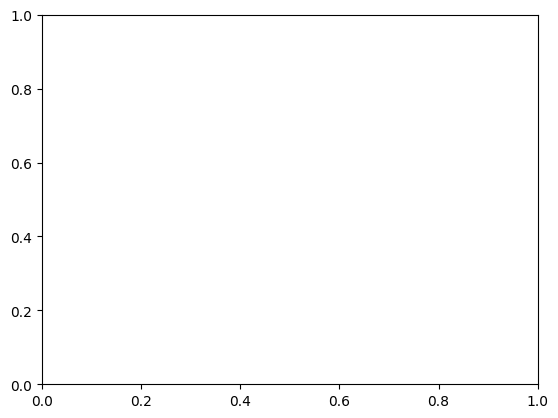

In [11]:
x = []
for i in range(5830):
    x.append(i)

import matplotlib.pyplot as plt

first_row_list = X_test.iloc[0].tolist()

plt.plot(x, prediction)
plt.plot(x,first_row_list)